In [1]:
from simulation import *
from aesthetics import *
from models import *
from data import *

import glob
import os as os
import re as re
import pandas as pd

%reload_ext autoreload
%autoreload 2
%matplotlib inline
mpl.rc('text', usetex=True)

In [4]:
from analysis import *

In [2]:
adk_dir = '../../md-data/adenylate-kinase/'
adk_unbound_files = sorted(glob.glob(adk_dir + 'AdKDihedHist_apo-4ake/' + '*'))
names = []
for file in range(len(adk_unbound_files)):
    name = os.path.splitext(os.path.basename(adk_unbound_files[file]))[0]
    name = re.search('^[^_]*', name).group(0)        
    if re.search('omega*', name):
        continue
    if re.search('chi3ASN*', name):
        continue
    if re.search('chi5LYS*', name):
        continue
    names.append(name)

In [27]:
summarize_fluxes(name = 'chi1PHE109', concentration=1e-3)

(-0.94685476234262589, 56.229802869953843, 222.30749006848782)

In [51]:
this = simulation(data_source='adk_md_data')
this.name = 'psiSER41'
this.cSubstrate = 1e-6
this.simulate()
print(np.mean(this.flux_u + this.flux_b))
print(max(abs(this.flux_ub)))
print( np.hstack((abs(this.flux_u), abs(this.flux_b))).max())

0.0217669826864
0.0123473558764
0.0685858820798


In [56]:
summarize_power_and_load(name = 'psiSER41', concentration = 1e-3, negative=False)

Looks good. Maximum power = 8.47761965598524 at index [9] with load = [ 0.9]


/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


Okay, so the obvious question is: why isn't this working? I can't find a maximum power for this angle by scanning in the range (0, 0.001, 0.0001) either negative or positive. Maybe I need to expand the range? No, that doesn't work either.

Do we actually know the maximum load that this angle can support? Aha, we do. It's huge -- over 1.0.

Alright, so if I scan in the range (0, 2, 0.1) then I *do* find the correct maximum power for this angle. Hmm.

But now what if I keep this increased range and try another angle. The known maximum load for `chi1PHE109` can support is -0.000311 with maximum power of 0.000046 at that load.

In [60]:
%timeit summarize_power_and_load(name = 'chi1PHE109', concentration = 1e-3, negative=True)

Testing loads from 0.0 to 1.9000000000000001 by 0.1


/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


Looks good. Maximum power = 0.04629956626465328 at index [1] with load = [ 0.1]
Testing loads from 0.0 to 1.9000000000000001 by 0.1
Looks good. Maximum power = 0.04629956626465328 at index [1] with load = [ 0.1]
Testing loads from 0.0 to 1.9000000000000001 by 0.1
Looks good. Maximum power = 0.04629956626465328 at index [1] with load = [ 0.1]
Testing loads from 0.0 to 1.9000000000000001 by 0.1
Looks good. Maximum power = 0.04629956626465328 at index [1] with load = [ 0.1]
1 loop, best of 3: 280 ms per loop


This is reasonable, but we really overestimate the maximum power. In order to capture a good value for the maximum power for each angle, I'll probably need to go up to +/- 2 and scan loads with the resolution of about 0.0001.

In [61]:
%timeit summarize_power_and_load(name = 'chi1PHE109', concentration = 1e-3, negative=True)

Testing loads from 0.0 to 2.0 by 0.0


/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


Looks good. Maximum power = 0.04680183746016732 at index [92] with load = [ 0.092]
Testing loads from 0.0 to 2.0 by 0.0
Looks good. Maximum power = 0.04696959731525625 at index [95] with load = [ 0.095]
Testing loads from 0.0 to 2.0 by 0.0
Looks good. Maximum power = 0.04696959731525625 at index [95] with load = [ 0.095]
Testing loads from 0.0 to 2.0 by 0.0
Looks good. Maximum power = 0.04696959731525625 at index [95] with load = [ 0.095]
1 loop, best of 3: 26.9 s per loop


Okay, so this gives about 30 seconds per loop and it didn't actually get closer to "optimized" estimate. I realize that the load is not small enough. If I drop the load another factor of 10...

In [62]:
%time summarize_power_and_load(name = 'chi1PHE109', concentration = 1e-3, negative=True)

Testing loads from 0.0 to 1.9999 by 0.0001


/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


Looks good. Maximum power = 0.04717006583563354 at index [1005] with load = [ 0.1005]
CPU times: user 26min 33s, sys: 37.2 s, total: 27min 10s
Wall time: 4min 31s


Okay this is going to take too long, so I can already tell we need tobe a little more clever. Somehow checking if the maximum keeps increasing... and stop when the maximum starts to decrease. 

Alright, I think I've got a good thing going now.

In [65]:
%time summarize_power_and_load(name = 'chi1PHE109', concentration = 1e-3, negative=True)

Looks good. Maximum power = 0.04355866030598664 with load = -0.1211
CPU times: user 9.07 s, sys: 235 ms, total: 9.3 s
Wall time: 1.56 s


In [67]:
%time summarize_power_and_load(name = 'psiSER41', concentration = 1e-3, negative=False)

Looks good. Maximum power = 8.146089770454653 with load = 1.1211
CPU times: user 8.67 s, sys: 227 ms, total: 8.9 s
Wall time: 1.49 s


/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


In [68]:
names[500]

'phiARG156'

In [69]:
%time summarize_power_and_load(name = 'phiARG156', concentration = 1e-3, negative=False)

Looks good. Maximum power = 1.1329716863104493e-05 with load = 0.0010000000000000002
CPU times: user 999 ms, sys: 31 ms, total: 1.03 s
Wall time: 191 ms


Let's just do a little manual spot check here.

  0.000000	 -0.000000
  0.000100	  0.000004
  0.000200	 -0.000000
  0.000300	 -0.000001
  0.000400	  0.000003
  0.000500	  0.000001
  0.000600	  0.000001
  0.000700	 -0.000010
  0.000800	 -0.000004
  0.000900	  0.000000
  0.001000	  0.000011
  0.001100	  0.000004
  0.001200	 -0.000023
  0.001300	 -0.000014
  0.001400	 -0.000003
  0.001500	  0.000036
  0.001600	 -0.000017
  0.001700	 -0.000002
  0.001800	  0.000004
  0.001900	  0.000005


(1e-06, 2e-05)

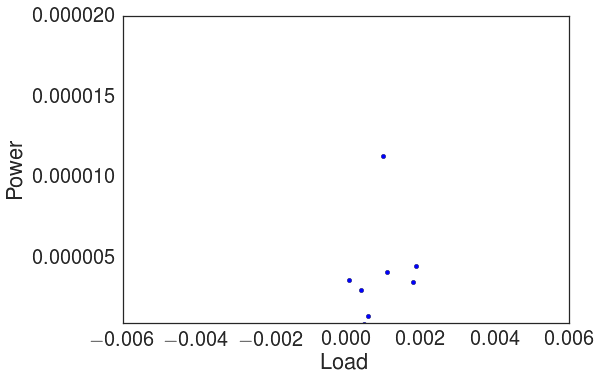

In [81]:
for slope in np.arange(0, 0.002, 0.0001):
    this = simulation(data_source='adk_md_data')
    this.name = 'phiARG156'
    this.cSubstrate = 1e-3
    this.load = True
    this.load_slope = slope
    this.simulate()
    print('{:10f}\t{:10f}'.format(slope, this.load_slope * np.mean(this.flux_u + this.flux_b)))
    plt.scatter(this.load_slope, this.load_slope * np.mean(this.flux_u + this.flux_b))
plt.ylabel('Power')
plt.xlabel('Load')
plt.ylim([1e-6, 2e-5])

Okay, looks good to me.